## MNIST classification

### Data loaders

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x/255.)
])

mnist_train = datasets.MNIST(
    root='./data', 
    train=True,  
    download=True,
    transform=transform
)

mnist_valid = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True,
    transform=transform
)

dl_train = DataLoader(mnist_train, batch_size=50, shuffle=True, drop_last=True)
dl_valid = DataLoader(mnist_valid, batch_size=50)

NameError: name 'DataLoader' is not defined

Checking one batch:

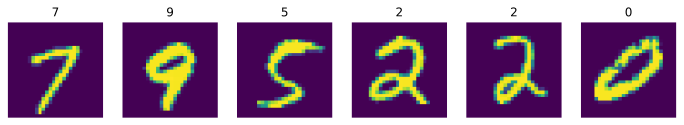

In [ ]:
x, y = next(iter(dl_train))

fig, ax = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    ax[i].imshow(x[i].permute(1, 2, 0))
    ax[i].axis("off")
    ax[i].set_title(y[i].item())

### Model architecture

In [ ]:
act_fn = {
    "relu": nn.ReLU(),
    "tanh": nn.Tanh(),
    "sigmoid": nn.Sigmoid()
}

def mnist_model(
        hidden_layers: int = 0,
        activation: str = None,
        hidden_size: int = 100,
        input_size: int = 784
    ):
    
    layers = [nn.Flatten()]

    m, n = input_size, hidden_size
    for i in range(hidden_layers):
        layers.append(nn.Linear(m, n))
        if activation:
            layers.append(act_fn[activation])
        m, n = hidden_size, hidden_size

    layers.append(nn.Linear(m, 10))
    model = nn.Sequential(*layers)

    return model


summary(mnist_model(3), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
            Linear-3                  [-1, 100]          10,100
            Linear-4                  [-1, 100]          10,100
            Linear-5                   [-1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


### Training

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

device = torch.device("mps")


@torch.no_grad()
def evaluate(model, dataloader):
    loss = 0
    correct = 0
    N = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)

        loss += F.cross_entropy(logits, y, reduction='sum').item()
        correct += sum(torch.argmax(logits, dim=1) == y).item()
        N += len(x)
    
    return {
        "loss": loss / N,
        "accs": correct / N
    }


def train_model(
        train_loader, 
        valid_loader,
        epochs=10, 
        hidden_layers=0, 
        activation=None, 
        input_size=784
    ):

    model = mnist_model(hidden_layers, activation, input_size=input_size).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loss = []
    valid_loss = []
    valid_accs = []

    for epoch in tqdm(range(epochs)):
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optim.step()
            optim.zero_grad()
            
            train_loss.append(loss.item())

        e = evaluate(model, valid_loader)
        valid_loss.append(e["loss"])
        valid_accs.append(e["accs"])
            
    return {
        "model": model,
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "valid_accs": valid_accs
    }

### Experiments

Effect of activation and depth on training:

In [ ]:
experiments = [
    {"hidden_layers":  0, "activation": None},
    {"hidden_layers":  1, "activation": None},
    {"hidden_layers":  1, "activation": "sigmoid"},
    {"hidden_layers": 10, "activation": "sigmoid"},
    {"hidden_layers":  1, "activation": "tanh"},
    {"hidden_layers":  1, "activation": "relu"},
    {"hidden_layers":  3, "activation": "relu"},
    {"hidden_layers": 10, "activation": "relu"},
]

results = {}

for params in experiments:
    results[tuple(params.values())] = train_model(dl_train, dl_valid, **params)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Plotting the results:

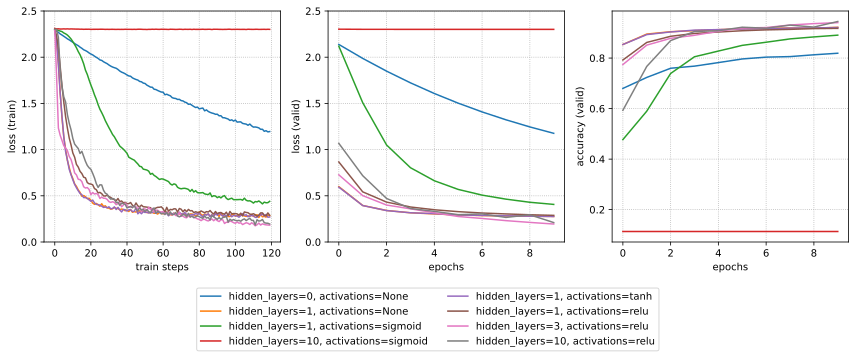

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, (params, hist) in enumerate(results.items()):
    ax[0].plot(torch.tensor(hist['train_loss']).view(-1, 100).mean(dim=1), color=f"C{i}")
    ax[1].plot(hist['valid_loss'], color=f"C{i}")
    ax[2].plot(hist['valid_accs'], label=f"hidden_layers={params[0]}, activations={params[1]}", color=f"C{i}")

ax[0].set_xlabel("train steps")
ax[1].set_xlabel("epochs")
ax[2].set_xlabel("epochs")
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')
ax[2].grid(linestyle='dotted')
ax[0].set_ylabel("loss (train)")
ax[1].set_ylabel("loss (valid)")
ax[2].set_ylabel("accuracy (valid)")
ax[1].set_ylim(0, 2.5)
ax[0].set_ylim(0, 2.5)

fig.legend(bbox_to_anchor=(0.5, -0.25), loc='lower center', ncol=2)
fig.tight_layout();

**Results.** 10 layers with sigmoid is remarkably bad. This is because of repeated squashing. ReLU networks perform well benefiting from added depth (although not too much). Tanh with a derivative of 1 at zero improves the performance of sigmoid.

## Appendix: Principal Component Analysis (PCA)

PCA looks for a hyperplane (e.g. with dimension $n \ll d$) such that the projection of the $d$-dimensional data on the hyperplane has iteratively maximal variance starting from the first orthonormal vector. In other words, the data is projected on a hyperplane such that the projected data points have maximal separability along each dimension.


![pca-ds-handbook](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.09-PCA-rotation.png)

**Figure.** PCA on a blob of data (left). Components in PCA space also shown (right). [Source]( https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html )

### PCs = eigenvectors

Let $\boldsymbol{\mathsf{S}} \in \mathbb{R}^{d \times d}$ be the sample covariance of the data. PCA starts with the optimization problem $\max_{\boldsymbol{\mathsf{u}}_1} {{\boldsymbol{\mathsf{u}}_1}^{\top}}\,\boldsymbol{\mathsf{S}}\,{\boldsymbol{\mathsf{u}}_1}$ such that ${{\boldsymbol{\mathsf{u}}_1}^{\top}}{\boldsymbol{\mathsf{u}}_1} = 1.$ The unit vector ${\boldsymbol{\mathsf{u}}_1}$ is called the first **principal component** (PC). This can be solved using Lagrange multiplers where it turns out that the first principal components is the eigenvecter of $\boldsymbol{\mathsf{S}}$ corresponding to the largest eigenvalue. The eigenvalue $\lambda_1$ also turns out to be the variance along that dimension.

Recall that $\boldsymbol{\mathsf{S}}$ is symmetric positive semidefnite so that it has $d$ nonnegative eigenvalues with corresponding $d$ orthonormal eigenvectors. In particular, we can order the eigenvalues as $\lambda_1 \leq \lambda_2 \leq \ldots \leq \lambda_d.$ The next principal components can be solved using the same Lagrange multipliers method with added constraints due to its orthogonality with earlier principal components. But we still get the same results that the principal component is the eigenvector ${\boldsymbol{\mathsf{u}}_j}$ corresponding to the next largest eigenvalue $\lambda_j.$

**Remark.** See [this video](https://www.youtube.com/watch?v=L-pQtGm3VS8) on PCA and [this video](https://www.youtube.com/watch?v=5A39Ht9Wcu0) on understanding Lagrange multipliers.

### First principal component

Here we solve the first PC of MNIST train using [power iteration](https://en.wikipedia.org/wiki/Power_iteration):

In [ ]:
def sample_covariance(size):
    """Compute covariance matrix of subset of data."""
    B = torch.randint(0, len(mnist_train), size=(size,))
    data = [mnist_train[b][0].view(-1) for b in B]

    X = torch.stack(data, dim=0)
    m = X.mean(dim=0)
    cov = (X - m).T @ (X - m) / X.shape[0]
    
    return {
        'cov': cov,
        'mean': m
    }

Computing the sample covariance of 30,000 random data points:

In [ ]:
examples = len(mnist_train)
sample = sample_covariance(examples)
cov = sample['cov']
total_variance = cov.diag().sum()

Using power iteration we can approximate $\lambda_1 {\boldsymbol{\mathsf{u}}_1}$:

In [ ]:
iterations = 1024
v = torch.ones(784)
for i in range(iterations):
    v = v @ cov
    s = torch.norm(v)
    v = v / s

It follows that the norm of this vector is the explained variance by the first PC:

In [ ]:
print(f"--iterations={iterations} --examples={examples}")
print(f"Total variance: {total_variance:.5f}")
print(f"Explained variance: {(s / total_variance).item() * 100:.2f}%")

--iterations=1024 --examples=60000
Total variance: 0.00081
Explained variance: 9.67%


See below for an explanation of **explained variance**.

### Explained variance

Recall that the trace of a matrix is equal to the sum of its eigenvalues. For the covariance matrix $\boldsymbol{\mathsf{S}}$, its trace is also the sum of all variances of the sample data along each of the input dimension. 
In other words, the sum of the variances along each principal component is equal to the sum of the variances along the the original input dimensions.
Hence, we call $\text{trace}(\boldsymbol{\mathsf{S}}) = \sum_{j=1}^d \lambda_j$ the **total variance** of the sample data. Below we will compute $\lambda_j / \sum_{j=1}^d \lambda_j$ to measure the amount of variance "explained" by one principal component. 

Computing the total variance:

In [ ]:
print(f"Total variance:    {total_variance:.5f}")
print(f"Total eigenvalues: {torch.linalg.eigvals(cov).sum().real.item():.5f}")

Total variance:    0.00081
Total eigenvalues: 0.00081


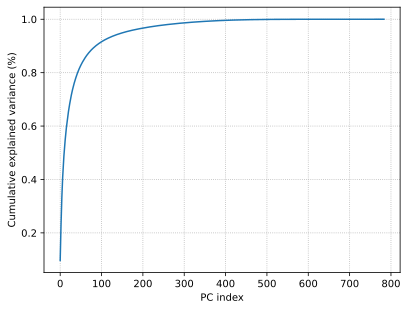

In [ ]:
cs = torch.cumsum(torch.linalg.eigvals(cov).real, dim=0)
plt.plot(cs / total_variance)
plt.grid(linestyle='dotted')
plt.ylabel("Cumulative explained variance (%)")
plt.xlabel("PC index");

**Remark.** This graph shows that we can preserve a significant percentage of the total variance by using only a small number of dimensions (e.g. ~100). See next section.

### PC decomposition

Note that the principal components are orthonormal vectors which can form a **basis** of the data space. The components along each dimension can be obtained using projection. The following reconstructs an instance using this technique of PCs as basis. The approximation should get better as we use more basis vectors (refer to the graph above):

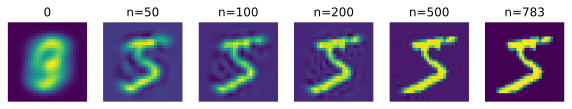

In [ ]:
# Sample data point
x, y = mnist_train[0]
x = x.view(-1)

eigvecs = torch.linalg.eig(cov).eigenvectors.real.T # 👈 >_<, (try without .T)
m = torch.clone(sample['mean'])

checkpoints = [50, 100, 200, 500, 783]
fig, ax = plt.subplots(1, len(checkpoints) + 1, figsize=(10, 3))
x_pca = m
ax[0].set_title(0)
ax[0].imshow(x_pca.view(28, 28))
ax[0].axis('off')

j = 1
for i in range(784):
    u = eigvecs[i]
    x_pca += ((x - m) @ u) * u
    if i + 1 in checkpoints:
        ax[j].set_title(f"n={i+1}")
        ax[j].imshow(x_pca.view(28, 28))
        ax[j].axis('off')
        j += 1

Principal components:

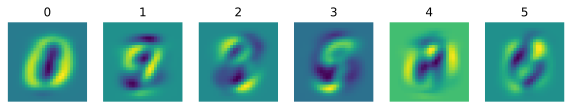

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(10, 3))

for i in range(6):
    u = eigvecs[i]
    ax[i].set_title(i)
    ax[i].imshow(u.view(28, 28))
    ax[i].axis('off')

### Dimensionality reduction

Here we project MNIST onto a 200-dimensional hyperplane (i.e. obtained using the first 200 principal components). This section also presents PCA in the framework of machine learning by using the training set to compute the PCs and then applying them on the validation dataset:

In [ ]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components

        # learned stuff
        self.cov = None
        self.mean = None
        self.components = None
        self.variances = None


    def fit(self, X):
        
        # compute sample covariance
        m = X.mean(dim=0)
        cov = (X - m).T @ (X - m) / X.shape[0]
        self.cov = cov
        self.mean = m

        # compute principal components
        eigvals, eigvecs = torch.linalg.eig(cov)
        self.components = eigvecs.real.T    # (!)
        self.variances  = eigvals.real
        
        n = self.n_components
        U = self.components[:n]
        explained_variance = sum(self.variances[:n]) / sum(self.variances)
        mae = (X - self.transform(X) @ U).abs().mean()
        print(f"Explained variance: {explained_variance * 100:.2f}%")
        print(f"MAE train: {mae: .2e}")


    def transform(self, x):
        if len(x.shape) != 2:
            raise Exception("Input must have dimension 2.")
        
        U = self.components[:self.n_components]
        m = self.mean
        return (x - m) @ U.T


    def explained_variance(self):
        if self.components is not None:
            cs = torch.cumsum(self.variances, dim=0)
            total_variance = sum(self.variances)
            return (cs / total_variance).tolist()
        else:
            raise Exception("PCA object not trained.")

**Remark.** Note that the eigenvector matrix has columns as eigenvectors. Hence the `.T` to get rows.

In [ ]:
pca = PCA(n_components=200)
data = [mnist_train[b][0].view(-1) for b in range(len(mnist_train))]
X = torch.stack(data, dim=0)
pca.fit(X)

Explained variance: 96.64%
MAE train:  5.29e-04


Custom transform using the PCA object:

In [ ]:
X_train, Y_train = zip(*[mnist_train[b] for b in range(len(mnist_train))])
X_valid, Y_valid = zip(*[mnist_valid[b] for b in range(len(mnist_valid))])

X_train = torch.stack(X_train, dim=0).view(-1, 784)
X_valid = torch.stack(X_valid, dim=0).view(-1, 784)

X_train_pca = pca.transform(X_train)
X_valid_pca = pca.transform(X_valid)

ds_train_pca = TensorDataset(X_train_pca, torch.tensor(Y_train))
ds_valid_pca = TensorDataset(X_valid_pca, torch.tensor(Y_valid))
dl_train_pca = DataLoader(ds_train_pca, batch_size=50, shuffle=True, drop_last=True)
dl_valid_pca = DataLoader(ds_valid_pca, batch_size=50)

Reconstructing MNIST instances using 200 components:

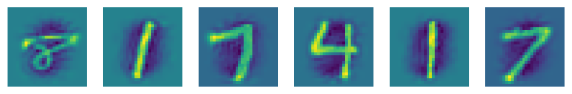

In [ ]:
x_pca, y = next(iter(dl_train_pca))
U = pca.components[:200]
x_recon = x_pca @ U

fig, ax = plt.subplots(1, 6, figsize=(10, 4))
for i in range(6):
    ax[i].imshow(x_recon[i].view(28, 28))
    ax[i].axis("off");

Looks good. Model trained on PCA data performed well:

In [ ]:
params = {"hidden_layers": 1, "activation": "sigmoid", "input_size": 200}
result_pca = train_model(dl_train_pca, dl_valid_pca, **params)

  0%|          | 0/10 [00:00<?, ?it/s]

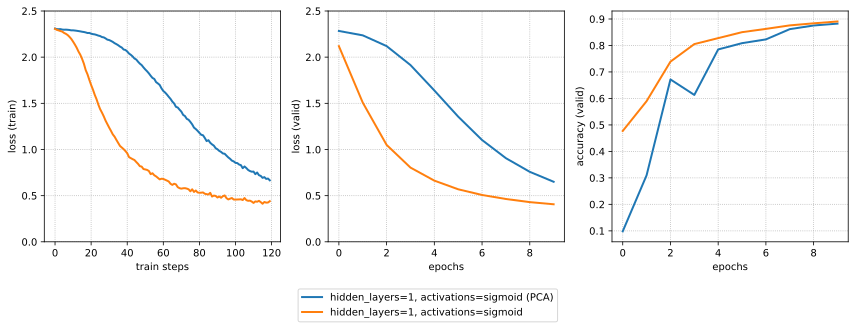

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(torch.tensor(result_pca['train_loss']).view(-1, 100).mean(dim=1), linewidth=2)
ax[1].plot(result_pca['valid_loss'], linewidth=2)
ax[2].plot(result_pca['valid_accs'], label=f"hidden_layers={params['hidden_layers']}, activations={params['activation']} (PCA)", linewidth=2)

ax[0].plot(torch.tensor(results[(1, 'sigmoid')]['train_loss']).view(-1, 100).mean(dim=1), linewidth=2)
ax[1].plot(results[(1, 'sigmoid')]['valid_loss'], linewidth=2)
ax[2].plot(results[(1, 'sigmoid')]['valid_accs'], label=f"hidden_layers=1, activations=sigmoid", linewidth=2)

ax[0].set_xlabel("train steps")
ax[1].set_xlabel("epochs")
ax[2].set_xlabel("epochs")
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')
ax[2].grid(linestyle='dotted')
ax[0].set_ylabel("loss (train)")
ax[1].set_ylabel("loss (valid)")
ax[2].set_ylabel("accuracy (valid)")
ax[1].set_ylim(0, 2.5)
ax[0].set_ylim(0, 2.5)

fig.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=1)
fig.tight_layout();